In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMRanker

In [2]:
race_df = pd.read_csv("../Scraping/csv/cleaned_race_data.csv")
horse_df = pd.read_csv("../Scraping/csv/cleaned_horse_data.csv")
horse_withrank_df = pd.read_csv("../Scraping/csv/cleaned_horse_withrank_data.csv")
february_df = pd.read_csv("../Scraping/csv/february_df.csv")

In [3]:
race_df.head(1)

,race_id,race_round,race_title,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,...,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,is_left_right_straight,distance,hour
0,201805010101,1,3歳未勝利,天候 : 晴,ダート : 不良,2018年1月27日,東京,16,3,6,...,8970,2500,1700,810,22830,12060,108820,左,1400,10


In [4]:
horse_withrank_df.head(1)

,race_id,rank,frame_number,horse_number,horse_id,age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,is_senba,is_mesu,is_osu,horse_weight_dif
0,201805010101,1,3,6,2015100407,3,54.0,1077,88.0,2.0,39.6,22.9,8.0,450.0,1076,843030,0,1,0,2.0


# モデル作成

In [5]:
race_df_for_merge = race_df[['race_id',
                             "race_round",
                             "race_title",
                             "weather",
                             'ground_status',
                             'where_racecourse',
                             'total_horse_number',
                             'is_left_right_straight',]]
merged_horse_df = pd.merge(horse_withrank_df, race_df_for_merge, on='race_id')

In [6]:
merged_horse_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20196 entries, 0 to 20195
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   race_id                 20196 non-null  int64  
 1   rank                    20196 non-null  int64  
 2   frame_number            20196 non-null  int64  
 3   horse_number            20196 non-null  int64  
 4   horse_id                20196 non-null  int64  
 5   age                     20196 non-null  int64  
 6   burden_weight           20196 non-null  float64
 7   rider_id                20196 non-null  int64  
 8   goal_time               20196 non-null  float64
 9   half_way_rank           20196 non-null  float64
 10  last_time               20196 non-null  float64
 11  odds                    20196 non-null  float64
 12  popular                 20196 non-null  float64
 13  horse_weight            20196 non-null  float64
 14  tamer_id                20196 non-null

In [7]:
merged_horse_df = merged_horse_df.drop(["race_title",
                                        'goal_time',
                                       'half_way_rank',
                                        'last_time',
                                        'odds'#,
                                        #'race_id',
                                       #'horse_weight',
                                       #'horse_weight_dif'
                                       ], axis=1)

In [8]:
merged_horse_df.to_csv("../Scraping/csv/merged_horse_withrank_df.csv", index=False )

In [9]:
#LabelEncoder
for column in ['weather',
               'ground_status',
               'where_racecourse',
               'is_left_right_straight']:
    le = LabelEncoder()
    le.fit(merged_horse_df[column])
    merged_horse_df[column] = le.transform(merged_horse_df[column])

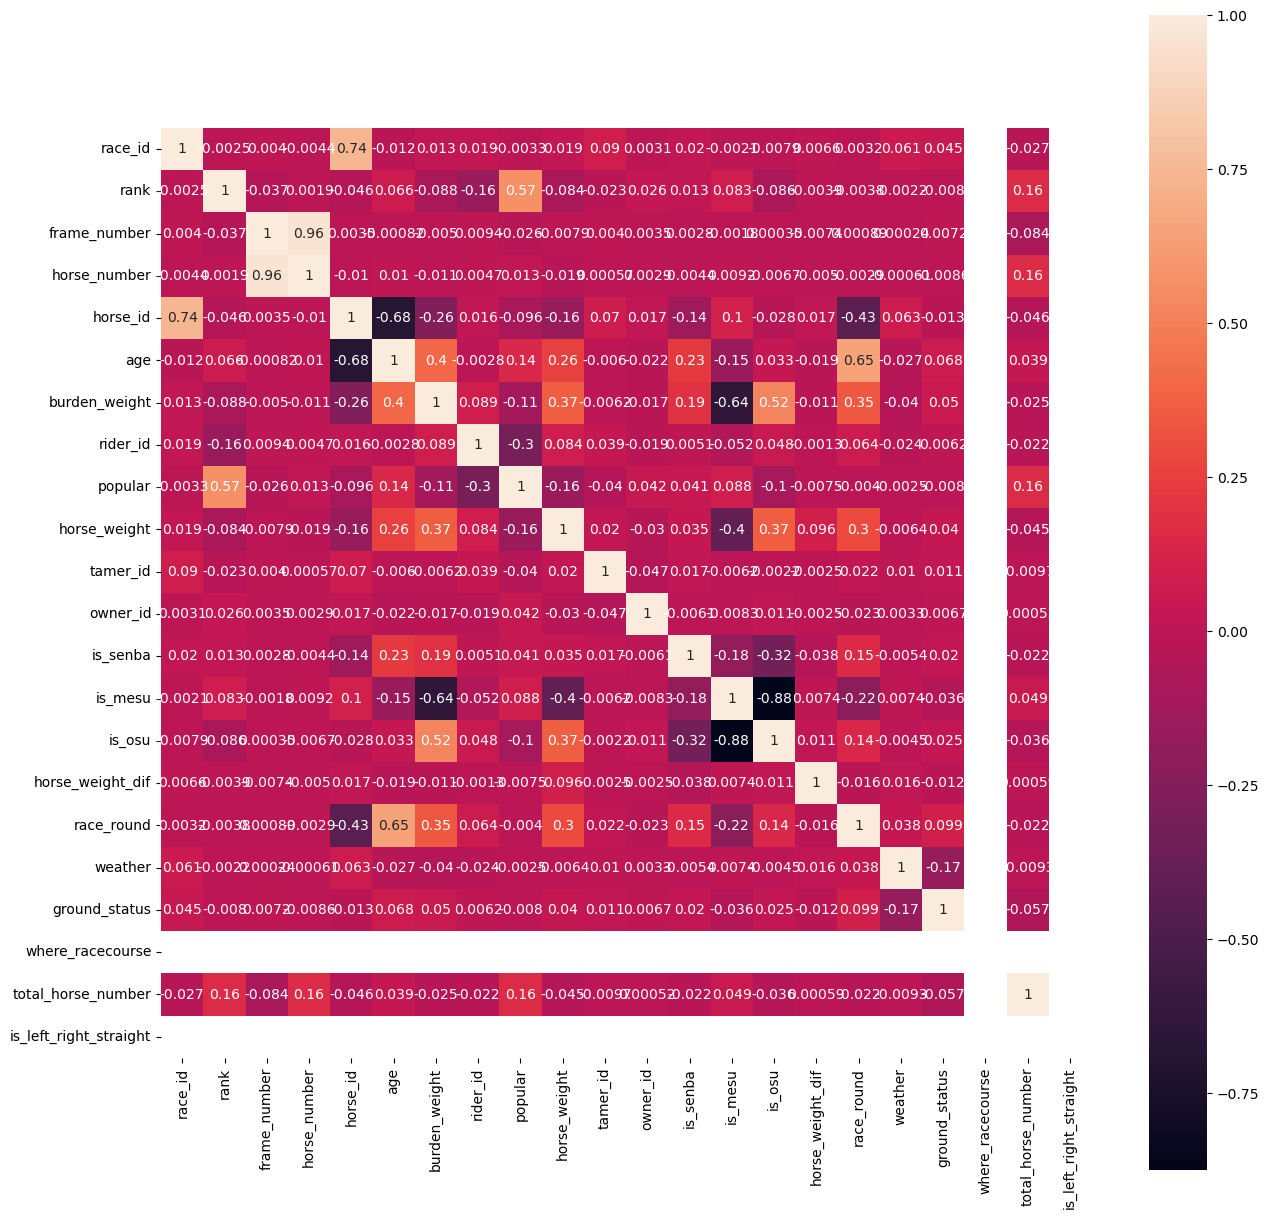

In [10]:
plt.figure(figsize=(15,15)) 
sns.heatmap(merged_horse_df.corr(), square=True, annot=True)
plt.show()

In [11]:
y = merged_horse_df['rank'].values
X = merged_horse_df.drop('rank', axis=1).values
X_df =merged_horse_df.drop('rank', axis=1)

In [12]:
X_train, X_val, y_train, y_val =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [13]:
#アダブースト
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1, 
                         random_state=1)

In [14]:
#アダブースト予測
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_val_pred = tree.predict(X_val)

tree_train = accuracy_score(y_train, y_train_pred)
tree_val = accuracy_score(y_val, y_val_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_val))


ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_val_pred = ada.predict(X_val)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_val = accuracy_score(y_val, y_val_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_val))

Decision tree train/test accuracies 0.108/0.109
AdaBoost train/test accuracies 0.141/0.125


In [15]:
#アダブースト特徴重要度
fi = ada.feature_importances_  
print('Feature Importances:')
for i, feat in enumerate(X_df.columns):
        print('\t{0:20s} : {1:>.3f}'.format(feat, fi[i]))

Feature Importances:
	race_id              : 0.010
	frame_number         : 0.016
	horse_number         : 0.042
	horse_id             : 0.082
	age                  : 0.068
	burden_weight        : 0.022
	rider_id             : 0.064
	popular              : 0.198
	horse_weight         : 0.138
	tamer_id             : 0.082
	owner_id             : 0.076
	is_senba             : 0.014
	is_mesu              : 0.024
	is_osu               : 0.002
	horse_weight_dif     : 0.088
	race_round           : 0.030
	weather              : 0.000
	ground_status        : 0.008
	where_racecourse     : 0.000
	total_horse_number   : 0.036
	is_left_right_straight : 0.000


# ハイパーパラメータ探索

In [16]:
#アダブーストハイパーパラメータ探索
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01, 0.1, 0.5]
# }

# ada = AdaBoostClassifier(base_estimator=tree,
#                          random_state=1)
# grid_search = GridSearchCV(ada, param_grid, cv=5)
# gs = grid_search.fit(X_train, y_train)

# y_train_pred = gs.predict(X_train)
# y_val_pred = gs.predict(X_val)

# gs_train = accuracy_score(y_train, y_train_pred) 
# gs_val = accuracy_score(y_val, y_val_pred) 
# print('GridSearch train/test accuracies %.3f/%.3f'
#       % (gs_train, gs_val))

In [17]:
#ベストパラメータ
# best_parameters = grid_search.best_params_
# best_parameters

In [18]:
X_test = february_df.drop(columns = ['rank']).values

In [19]:
y_test_pred = ada.predict(X_test)
y_test_pred

array([15, 16, 16, 16, 16, 16, 15, 15, 16, 15, 15, 15, 15, 15, 16, 15],
      dtype=int64)

# lightgbm ranking

In [20]:
columns_to_use = ['frame_number', 
                  'horse_number', 
                  'age',
                  'burden_weight',
                  'rider_id',
                  'popular',
                 'horse_weight',
                 'tamer_id',
                 'owner_id',
                  'is_senba',
                  'is_mesu',
                  'is_osu',
                  'horse_weight_dif'
                 ]

train_X = horse_withrank_df[columns_to_use]
train_y = horse_withrank_df["rank"]

test_X = february_df[columns_to_use]

display(train_X)
display(train_y)

,frame_number,horse_number,age,burden_weight,rider_id,popular,horse_weight,tamer_id,owner_id,is_senba,is_mesu,is_osu,horse_weight_dif
0,3,6,3,54.0,1077,8.0,450.0,1076,843030,0,1,0,2.0
1,1,1,3,54.0,422,4.0,474.0,1079,399030,0,1,0,12.0
2,2,4,3,54.0,5386,3.0,456.0,1108,252030,0,1,0,-2.0
3,7,13,3,54.0,1122,5.0,424.0,1090,12033,0,1,0,-2.0
4,6,11,3,54.0,1096,6.0,460.0,1029,132030,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20191,6,11,4,57.0,5473,6.0,504.0,438,790031,1,0,0,10.0
20192,1,2,4,57.0,5626,9.0,452.0,1111,788800,0,0,1,0.0
20193,3,5,4,57.0,5366,4.0,498.0,427,929002,0,0,1,2.0
20194,4,8,5,57.0,1115,10.0,486.0,1180,180800,1,0,0,-18.0


0         1
1         2
2         3
3         4
4         5
         ..
20191    12
20192    13
20193    14
20194    15
20195    16
Name: rank, Length: 20196, dtype: int64

In [21]:
train_baskets = horse_withrank_df.groupby(["race_id"])["horse_id"].count().values
display(horse_withrank_df.groupby(["race_id"])["horse_id"].count())

race_id
201805010101    16
201805010102    16
201805010103    16
201805010106    16
201805010107    15
                ..
202205050801    16
202205050803    16
202205050805    16
202205050807    16
202205050810    16
Name: horse_id, Length: 1343, dtype: int64

In [22]:
# Class instance
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type="gain",
    verbose=10
)

# Fit model
ranker = ranker.fit(train_X, train_y, group=train_baskets)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.020657
[LightGBM] [Debug] init for col-wise cost 0.000021 seconds, init for row-wise cost 0.001472 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 20196, number of used features: 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9


In [23]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

popular 0.9582873099382181
owner_id 0.008972178751465252
frame_number 0.007128237773335175
horse_number 0.007051497529037446
rider_id 0.006254544927673244
horse_weight_dif 0.005589447487989359
horse_weight 0.00498824170228313
age 0.0017285418899983377
is_osu 0.0
is_mesu 0.0
is_senba 0.0
tamer_id 0.0
burden_weight 0.0


In [24]:
# Create predict
february_df["preds"] = ranker.predict(test_X)

# Create dict. key: customer_id values: prediction
c_id2predicted_article_ids = february_df \
    .sort_values(["horse_id", "preds"], ascending=False) \
    .groupby(["horse_id"])["race_id"].apply(list).to_dict()

In [25]:
display(february_df.sort_values(["horse_id", "preds"], ascending=False))

,race_id,rank,frame_number,horse_number,horse_id,age,burden_weight,popular,rider_id,horse_weight,...,is_mesu,is_osu,horse_weight_dif,race_round,weather,ground_status,where_racecourse,total_horse_number,is_left_right_straight,preds
11,202305010811,NaN,6,12,2019102737,4,58,11,5212,480,...,0,1,-2,11,1,0,0,16,0,0.003015
12,202305010811,NaN,7,13,2019102512,4,56,5,5404,478,...,1,0,0,11,1,0,0,16,0,-0.093432
3,202305010811,NaN,2,4,2019101667,4,58,2,5386,526,...,0,1,-12,11,1,0,0,16,0,-0.158253
6,202305010811,NaN,4,7,2018110015,5,58,1,1163,518,...,0,1,-4,11,1,0,0,16,0,-0.179897
1,202305010811,NaN,1,2,2017190001,6,54,7,5509,470,...,0,1,0,11,1,0,0,16,0,-0.033416
5,202305010811,NaN,3,6,2017106404,6,58,3,1115,508,...,0,1,6,11,1,0,0,16,0,-0.158253
7,202305010811,NaN,4,8,2017105279,6,58,14,422,550,...,0,0,-2,11,1,0,0,16,0,0.164924
2,202305010811,NaN,2,3,2017103641,6,58,10,5621,502,...,0,1,0,11,1,0,0,16,0,0.079641
9,202305010811,NaN,5,10,2017103513,6,58,6,5339,544,...,0,1,-6,11,1,0,0,16,0,-0.093432
8,202305010811,NaN,5,9,2017100024,6,56,8,1170,490,...,1,0,6,11,1,0,0,16,0,0.001140
